# Import modules

In [1]:
import qiskit
import pylatexenc
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import gym
from functools import reduce
from collections import deque, defaultdict

In [3]:
import qiskit
import numpy as np
import matplotlib.pyplot as plt
import math, random, time, itertools
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer
from qiskit.quantum_info.operators import Operator
from qiskit.circuit import Parameter, ParameterVector
from tqdm.notebook import tqdm
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp, CircuitOp, AerPauliExpectation
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import OpflowQNN
from qiskit.utils import QuantumInstance, algorithm_globals

In [4]:
from Curling import Curling

# Build CIrucit

In [5]:
def add_hadamard(circuit, n_qubits):
    for i in range(n_qubits):
        circuit.h(i)
def add_single_qubit_rotation(circuit, Paramvector, n_qubits):
    for i in range(n_qubits):
        circuit.rx(Paramvector[i*3], i)
        circuit.ry(Paramvector[i*3+1], i)
        circuit.rz(Paramvector[i*3+2], i)
def add_encoding_layer(circuit, Paramvector, n_qubits):
    for i in range(n_qubits):
        circuit.rx(Paramvector[i], i)
def add_entangling_layer(circuit, n_qubits):
    qubits = [i for i in range(n_qubits)]
    for c in itertools.combinations(qubits, 2):
        circuit.cz(c[0], c[1])

In [6]:
def build_circuit(n_qubits, n_layers):
    qr = QuantumRegister(n_qubits)
    qc = QuantumCircuit(qr)
    
    param_rot = ParameterVector('Rot', 3*n_qubits*(n_layers+1))
    param_enc = ParameterVector('Enc', n_qubits*n_layers)
    
    print(len(param_rot))
    
#     add_hadamard(qc, n_qubits)
    for l in range(n_layers):
        # Variational + Encoding Layer
        add_single_qubit_rotation(qc, param_rot[l*(3*n_qubits):(l+1)*(3*n_qubits)], n_qubits)
        qc.barrier()
        add_entangling_layer(qc, n_qubits)
        qc.barrier()
        # Encoding Layer
        add_encoding_layer(qc, param_enc[l*n_qubits:(l+1)*n_qubits], n_qubits)
        qc.barrier()
    # Last Variational Layer
    add_single_qubit_rotation(qc, param_rot[n_layers*(3*n_qubits):(n_layers+1)*(3*n_qubits)], n_qubits)
    
    return qc, param_rot, param_enc

18


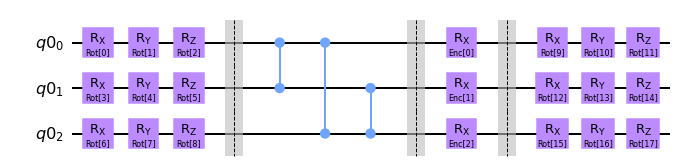

In [7]:
def draw_example():
    quantum_circuit, param_rot, param_enc = build_circuit(n_qubits=3, n_layers=1)
    return quantum_circuit
draw_example().draw('mpl')

In [8]:
circuit, rot_params, enc_params = build_circuit(n_qubits=3, n_layers=1)

18


In [9]:
# Observable = Z^Z^Z

In [10]:
# psi = CircuitStateFn(primitive=circuit, coeff=1.)
# op = ~StateFn(Observable) @ psi

In [11]:
# print(op)

In [12]:
# # set method to calculcate expected values
# expval = AerPauliExpectation()

# # define gradient method
# gradient = Gradient()

# # define quantum instances (statevector and sample based)
# qi_sv = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))

# # we set shots to 10 as this will determine the number of samples later on.
# qi_qasm = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1000)

In [13]:
# qnn = OpflowQNN(operator=op, input_params=enc_params, weight_params=rot_params, 
#                 exp_val=expval, gradient=gradient, quantum_instance=qi_sv, input_gradients=True)

In [14]:
# # define (random) input and weights
# input1 = algorithm_globals.random.random(qnn.num_inputs)
# input1 = algorithm_globals.random.random(qnn.num_inputs)
# input1 = nn.Parameter(torch.rand(qnn.num_inputs))
# weights1 = nn.Parameter(torch.rand(qnn.num_weights))

In [15]:
# qnn.forward(input1.detach(), weights1.detach())

In [16]:
# qnn.backward(input1.detach(), weights1.detach())

In [17]:
# num_inputs = 3
# num_samples = 20
# XX = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
# X_ = torch.Tensor(XX)

In [18]:
# X_

In [19]:
# model = TorchConnector(qnn, initial_weights=weights1)

In [20]:
class PQC_with_DataReuploading(nn.Module):
    def __init__(self, n_qubits, n_layers, output_dim, observables=None, activation='linear'):
        super().__init__()
        
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.output_dim = output_dim
        self.activation = activation
        
        if observables == None:
            self.observables = Z^n_qubits
        else:
            self.observables = observables
        
        # Build circuits / Parameter Vectors
        self.circuit, self.rot_params, self.enc_params = build_circuit(self.n_qubits, self.n_layers)
        self.len_rot_params = len(self.rot_params)
        self.len_enc_params = len(self.enc_params)
        
        self.psi = CircuitStateFn(primitive=self.circuit, coeff=1.)
        self.Op = ~StateFn(self.observables) @ self.psi
        
        # set method to calculcate expected values
        expval = AerPauliExpectation()
        # define gradient method
        gradient = Gradient()
        # define quantum instances (statevector and sample based)
        qi_sv = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))
        # we set shots to 10 as this will determine the number of samples later on.
        qi_qasm = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1000)
        
        self.qnn = OpflowQNN(operator=self.Op, input_params=self.enc_params, weight_params=self.rot_params, 
                             exp_val=expval, gradient=gradient, quantum_instance=qi_sv, input_gradients=True)
        
        self.total_params = []
        for p in self.rot_params:
            self.total_params.append(p)
        for p in self.enc_params:
            self.total_params.append(p)
        
        # Initial Parameters for circuit
        self.rot_param_vals = nn.Parameter(np.pi * torch.rand(len(self.rot_params)))
        self.enc_param_vals = nn.Parameter(torch.ones(len(self.enc_params)))
        
        # Parameter for circuit output
        self.w = nn.Parameter(nn.Parameter(torch.rand(self.output_dim)))
        
    def forward(self, inputs):
        # Input: State values -> Need to insert into Encoding gates with scaling parameters(encoding params)
        input_tiled = inputs.tile(self.n_layers)
        input_scaled = self.enc_param_vals * input_tiled
        input_params = input_scaled
    
        expectation = self.qnn.forward(input_params.detach(), self.rot_param_vals.detach())
        
        action_exp = torch.tensor(expectation) * self.w
        action_prob = F.softmax(action_exp, dim=1)
        
        return action_prob

    def backward(self, inputs):
        input_tiled = inputs.tile(self.n_layers)
        input_scaled = self.enc_param_vals * input_tiled
        input_params = input_scaled
        expectation = self.qnn.forward(input_params.detach(), self.rot_param_vals.detach())
        enc_grad, rot_grad = self.qnn.backward(input_params.detach(), self.rot_param_vals.detach())
        w_grad = torch.tensor(expectation).tile(self.output_dim)
        return torch.tensor(rot_grad.squeeze()), torch.tensor(enc_grad.squeeze()), w_grad
        
#     def get_grad(self, inputs):
#         input_tiled = inputs.tile(self.n_layers)
#         input_scaled = self.enc_param_vals * input_tiled
#         input_params = input_scaled
        
#         value_dict = {}
#         for i, p in enumerate(self.rot_params):
#             value_dict[p] = self.rot_param_vals[i].item()
#         for i, p in enumerate(self.enc_params):
#             value_dict[p] = input_params[i].detach().item()
        
#         psi = CircuitStateFn(primitive=self.circuit, coeff=1.)
#         op = ~StateFn(self.observables) @ psi
#         grad = Gradient(grad_method='param_shift').convert(operator=op, params=self.total_params)
# #         grad = Gradient(grad_method='fin_diff').convert(operator=op, params=self.total_params)
#         grad_val = grad.assign_parameters(value_dict).eval()
#         rot_grad = torch.tensor([grad_val[i].real for i in range(self.len_rot_params)])
#         enc_grad = torch.tensor([grad_val[self.len_rot_params + i].real for i in range(self.len_enc_params)])
        
#         expectation = ~ psi @ self.observables @ psi
#         expectation_val = expectation.assign_parameters(value_dict).eval().real
#         w_grad = torch.tensor([float(expectation_val)*self.w[i] for i in range(len(self.w))])
#         return rot_grad, enc_grad, w_grad
    
#     def get_grad2(self, inputs):
#         input_tiled = inputs.tile(self.n_layers)
#         input_scaled = self.enc_param_vals * input_tiled
#         input_params = input_scaled
            
#         circ_psi = CircuitStateFn(primitive=self.circuit, coeff=1.)
#         expectation = ~ circ_psi @ self.observables @ circ_psi
                
#         value_dict = {}
#         for i, p in enumerate(self.rot_params):
#             value_dict[p] = self.rot_param_vals[i].item()
#         for i, p in enumerate(self.enc_params):
#             value_dict[p] = input_params[i].detach().item()
        
#         rot_grad = []
#         for idx in range(self.len_rot_params):

#             value_dict[self.rot_params[idx]] += np.pi/2
#             expectation_plus = expectation.assign_parameters(value_dict).eval().real
#             value_dict[self.rot_params[idx]] -= np.pi
#             expectation_minus = expectation.assign_parameters(value_dict).eval().real
#             rot_grad.append(0.5*(expectation_plus - expectation_minus))
        
#         value_dict[self.rot_params[idx]] += np.pi/2
        
#         enc_grad = []
#         for idx in range(self.len_enc_params):
#             value_dict = {}
#             for i, p in enumerate(self.rot_params):
#                 value_dict[p] = self.rot_param_vals[i].item()
#             for i, p in enumerate(self.enc_params):
#                 value_dict[p] = input_params[i].detach().item()

#             value_dict[self.enc_params[idx]] += np.pi/2
#             expectation_plus = expectation.assign_parameters(value_dict).eval().real
#             value_dict[self.enc_params[idx]] -= np.pi
#             expectation_minus = expectation.assign_parameters(value_dict).eval().real
#             enc_grad.append(0.5*(expectation_plus - expectation_minus))
        
#         value_dict[self.enc_params[idx]] += np.pi/2
        
#         expectation = expectation.assign_parameters(value_dict).eval().real
#         w_grad = torch.tensor([float(expectation)*self.w[i] for i in range(len(self.w))])
        
#         return torch.tensor(rot_grad), torch.tensor(enc_grad), w_grad

In [21]:
policy = PQC_with_DataReuploading(n_qubits=2, n_layers=1, output_dim=2)

12


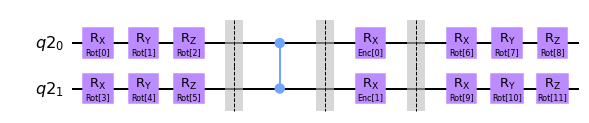

In [22]:
policy.circuit.draw('mpl')

In [23]:
inputs = torch.rand((10,2))

In [24]:
policy.forward(inputs)

tensor([[0.4187, 0.5813],
        [0.4370, 0.5630],
        [0.4135, 0.5865],
        [0.4627, 0.5373],
        [0.4011, 0.5989],
        [0.4395, 0.5605],
        [0.4841, 0.5159],
        [0.3997, 0.6003],
        [0.4211, 0.5789],
        [0.4094, 0.5906]], dtype=torch.float64, grad_fn=<SoftmaxBackward0>)

In [25]:
s = time.time()
a,b,c = policy.backward(inputs)
print(time.time()-s)

0.9260413646697998


In [26]:
a.shape

torch.Size([10, 12])

# Make Quantum Agent

In [27]:
class QuantumAgent():
    def __init__(self, input_state_dim, n_actions, n_layers=1):
        self.policy = PQC_with_DataReuploading(n_qubits=input_state_dim, n_layers=n_layers, 
                                               output_dim=n_actions, observables=None,
                                               activation='linear')
        self.n_layers = n_layers
        self.variational_optim = torch.optim.Adam([self.policy.rot_param_vals], lr=2)
        self.encoding_optim = torch.optim.Adam([self.policy.enc_param_vals], lr=2)
        self.weight_optim = torch.optim.Adam([self.policy.w], lr=2)
        
        self.optims = [self.variational_optim, self.encoding_optim, self.weight_optim]
        
    def get_actions(self, input_state):
        return self.policy.forward(input_state)
    
    def update_policy(self, states, id_action_pairs, returns, action_probs, batch_size):
        r_grad, e_grad, w_grad = self.policy.backward(states)
        
        p_actions = torch.tensor([action_probs[id_action_pairs[i][0], id_action_pairs[i][1]] for i in range(action_probs.shape[0])])
        p_actions = p_actions.reshape(p_actions.shape[0], -1)
        action_idxs = id_action_pairs[:,1]
        
        returns = returns.reshape(returns.shape[0], -1)
        action_weights = agent.policy.w.detach().numpy()[id_action_pairs[:,1]]
        action_weights = action_weights[:,np.newaxis]
        
        w = agent.policy.w.tile(len(states)).reshape(len(states),-1)
        
        rot_grad = returns * ( r_grad * torch.tensor(action_weights) - torch.sum(p_actions * w) * r_grad)
        input_scaled = self.policy.enc_param_vals * states.tile(self.n_layers)
        
        enc_grad = returns * ( e_grad * torch.tensor(action_weights) - input_scaled * torch.sum(p_actions * w) * e_grad)
        weight_grad = returns * ( w_grad * torch.tensor(action_weights) - torch.sum(p_actions * w) * w_grad)
        
        for opt in self.optims:
            opt.zero_grad()
        
        rot_update = (torch.sum(rot_grad.detach(), dim=0) / batch_size).type(torch.float32)
        enc_update = (torch.sum(enc_grad, dim=0).detach() / batch_size).type(torch.float32)
        w_update = (torch.sum(weight_grad, dim=0).detach() / batch_size).type(torch.float32)
                
        self.policy.rot_param_vals.grad = rot_update
        self.policy.enc_param_vals.grad = enc_update
        self.policy.w.grad = w_update
                
        self.variational_optim.step()
        self.encoding_optim.step()
        self.weight_optim.step()
        
#         for i in range(len(states)):
#             r_grad += returns[i] * (rot_gradient[i]*self.policy.w[action_idxs[i]] 
#                                     - torch.sum(p_actions[i]*self.policy.w)*rot_gradient[i])
   
#             input_scaled = self.policy.enc_param_vals * states[i].tile(self.n_layers)
#             e_grad +=  returns[i] * (enc_gradient[i]*self.policy.w[action_idxs[i]] 
#                                      - input_scaled * torch.sum(p_actions[i]*self.policy.w)*enc_gradient[i])
            
#             w_grad += returns[i] * (w_gradient[i]*self.policy.w[action_idxs[i]] 
#                                     - torch.sum(p_actions[i]*self.policy.w)*w_gradient[i])
        
#     def update_policy(self, states, id_action_pairs, returns, action_probs, batch_size):
#         rot_gradient, enc_gradient, w_gradient = [], [], []
#         for s in states:
#             r_grad, e_grad, w_grad = self.policy.get_grad(s)
#             rot_gradient.append(np.array(r_grad))
#             enc_gradient.append(np.array(e_grad))
#             w_gradient.append(np.array(w_grad))
#         rot_gradient = torch.mean(torch.from_numpy(np.array(rot_gradient)), dim=0)
#         enc_gradient = torch.mean(torch.from_numpy(np.array(enc_gradient)), dim=0)
#         w_gradient = torch.mean(torch.from_numpy(np.array(w_gradient)), dim=0)
        
#         p_actions = torch.tensor([action_probs[id_action_pairs[i][0], id_action_pairs[i][1]] for i in range(action_probs.shape[0])])
#         log_probs = torch.log(p_actions)
#         loss = torch.sum(-log_probs * returns) / batch_size
        
#         for opt in self.optims:
#             opt.zero_grad()
        
#         self.policy.rot_param_vals.grad = loss * rot_gradient
#         self.policy.enc_param_vals.grad = loss * enc_gradient
#         self.policy.w.grad = loss * w_gradient
                
#         self.variational_optim.step()
#         self.encoding_optim.step()
#         self.weight_optim.step()

In [28]:
n_qubits = 2 # Dimension of the state vectors in CartPole
n_layers = 1
n_actions = 2 # Number of actions in CartPole
agent = QuantumAgent(input_state_dim = n_qubits, n_actions=n_actions, n_layers=n_layers)

12


# Run Episodes and Update Policy

In [29]:
def gather_episodes(state_bounds, n_actions, agent, n_episodes, env_name):
    """Interact with environment in batched fashion."""

    trajectories = [defaultdict(list) for _ in range(n_episodes)]
    envs = [Curling() for _ in range(n_episodes)]
#     envs = [gym.make(env_name) for _ in range(n_episodes)]

    done = [False for _ in range(n_episodes)]
    states = [e.reset() for e in envs]

    while not all(done):
        unfinished_ids = [i for i in range(n_episodes) if not done[i]]
        normalized_states = [s/state_bounds for i, s in enumerate(states) if not done[i]]

        for i, state in zip(unfinished_ids, normalized_states):
            trajectories[i]['states'].append(state)

        states = torch.from_numpy(np.array(normalized_states))
        action_probs = agent.get_actions(states)

        # Store action and transition all environments to the next state
        states = [None for i in range(n_episodes)]
        for i, action_prob in zip(unfinished_ids, action_probs.detach().numpy()):
            action = np.random.choice(n_actions, p=action_prob)
            states[i], reward, done[i], _ = envs[i].step(action)
            trajectories[i]['actions'].append(action)
            trajectories[i]['rewards'].append(reward)
            trajectories[i]['action probs'].append(action_prob)

    return trajectories

def compute_returns(rewards_history, gamma):
    """Compute discounted returns with discount factor `gamma`."""
    returns = []
    discounted_sum = 0
    for r in rewards_history[::-1]:
        discounted_sum = r + gamma * discounted_sum
        returns.insert(0, discounted_sum)

    # Normalize them for faster and more stable learning
    returns = np.array(returns)
    returns = (returns - np.mean(returns)) / (np.std(returns) + 1e-8)
    returns = returns.tolist()

    return returns

In [47]:
env_name = "CartPole-v1"
# env_name = "Curling"
if env_name == "CartPole-v1":
    state_bounds = np.array([2.4, 2.5, 0.21, 2.5])
elif env_name == 'Curling':
    state_bounds = np.array([3, 1])
gamma = 1
batch_size = 20
n_episodes = 5000

In [48]:
# Start training the agent
episode_reward_history = []
# Monitoring reward
monitor_reward_history = []
for batch in tqdm(range(n_episodes // batch_size)):
    # Gather episodes
    episodes = gather_episodes(state_bounds, n_actions, agent, batch_size, env_name)

    # Group states, actions and returns in numpy arrays
    states = torch.from_numpy(np.concatenate([ep['states'] for ep in episodes]))
    actions = torch.from_numpy(np.concatenate([ep['actions'] for ep in episodes]))
    action_probs = torch.from_numpy(np.concatenate([ep['action probs'] for ep in episodes]))
    rewards = [ep['rewards'] for ep in episodes]
    returns = np.concatenate([compute_returns(ep_rwds, gamma) for ep_rwds in rewards])
    returns = torch.from_numpy(np.array(returns))

    id_action_pairs = torch.from_numpy(np.array([[i, a] for i, a in enumerate(actions)]))

    # Update model parameters.
    agent.update_policy(states, id_action_pairs, returns, action_probs, batch_size)
#     print(action_probs)

    if batch % 5 == 1:
        # Gather episodes
        episodes = gather_episodes(state_bounds, n_actions, agent, 100, env_name)

        # Group states, actions and returns in numpy arrays
        states = torch.from_numpy(np.concatenate([ep['states'] for ep in episodes]))
        actions = torch.from_numpy(np.concatenate([ep['actions'] for ep in episodes]))
        action_probs = torch.from_numpy(np.concatenate([ep['action probs'] for ep in episodes]))
        rewards = [ep['rewards'] for ep in episodes]
        # Store collected rewards
        temp_hist = []
        for ep_rwds in rewards:
            temp_hist.append(np.sum(ep_rwds))
        avg_rewards = np.mean(temp_hist)
        monitor_reward_history.append(avg_rewards)
        
        print('Monitored episode', 50,
              'Average Monitored rewards: ', avg_rewards)

    # Store collected rewards
    for ep_rwds in rewards:
        episode_reward_history.append(np.sum(ep_rwds))

    avg_rewards = np.mean(episode_reward_history[-batch_size:])

    print('Finished episode', (batch + 1) * batch_size,
          'Average rewards: ', avg_rewards)

    if avg_rewards >= 500.0:
        break

  0%|          | 0/250 [00:00<?, ?it/s]

Finished episode 20 Average rewards:  0.5
Monitored episode 50 Average Monitored rewards:  0.57
Finished episode 40 Average rewards:  0.5
Finished episode 60 Average rewards:  0.6
Finished episode 80 Average rewards:  0.6
Finished episode 100 Average rewards:  0.45
Finished episode 120 Average rewards:  0.55
Monitored episode 50 Average Monitored rewards:  0.46
Finished episode 140 Average rewards:  0.5
Finished episode 160 Average rewards:  0.4
Finished episode 180 Average rewards:  0.5
Finished episode 200 Average rewards:  0.55
Finished episode 220 Average rewards:  0.6
Monitored episode 50 Average Monitored rewards:  0.5
Finished episode 240 Average rewards:  0.55
Finished episode 260 Average rewards:  0.5
Finished episode 280 Average rewards:  0.45
Finished episode 300 Average rewards:  0.65
Finished episode 320 Average rewards:  0.5
Monitored episode 50 Average Monitored rewards:  0.5
Finished episode 340 Average rewards:  0.55
Finished episode 360 Average rewards:  0.6
Finished 

Finished episode 3020 Average rewards:  0.4
Monitored episode 50 Average Monitored rewards:  0.43
Finished episode 3040 Average rewards:  0.55
Finished episode 3060 Average rewards:  0.4
Finished episode 3080 Average rewards:  0.45
Finished episode 3100 Average rewards:  0.3
Finished episode 3120 Average rewards:  0.3
Monitored episode 50 Average Monitored rewards:  0.5
Finished episode 3140 Average rewards:  0.5
Finished episode 3160 Average rewards:  0.65
Finished episode 3180 Average rewards:  0.5
Finished episode 3200 Average rewards:  0.5
Finished episode 3220 Average rewards:  0.3
Monitored episode 50 Average Monitored rewards:  0.44
Finished episode 3240 Average rewards:  0.55
Finished episode 3260 Average rewards:  0.45
Finished episode 3280 Average rewards:  0.35
Finished episode 3300 Average rewards:  0.4
Finished episode 3320 Average rewards:  0.35
Monitored episode 50 Average Monitored rewards:  0.55
Finished episode 3340 Average rewards:  0.6
Finished episode 3360 Average 

(array([143.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0., 157.]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

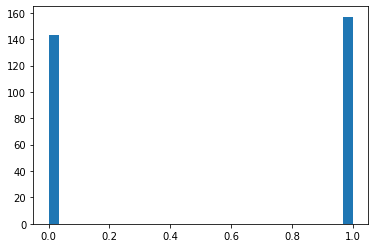

In [51]:
plt.hist(episode_reward_history[:300], bins=30)

(array([154.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0., 146.]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

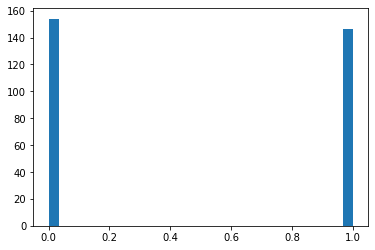

In [52]:
plt.hist(episode_reward_history[-300:], bins=30)

In [53]:
len(episode_reward_history)

9000

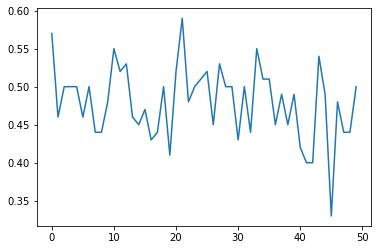

In [54]:
plt.plot(monitor_reward_history)